In [120]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
from scipy.stats import shapiro
from scipy.stats import levene
from scipy import stats
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from IPython.display import display, HTML
pd.options.display.float_format = '{:.3f}'.format


In [121]:
df = pd.read_csv('PlantGrowth.csv')
df = df[['group', 'weight']]
ctrl = df[df['group'] == 'ctrl']['weight']
trt1 = df[df['group'] == 'trt1']['weight']
trt2 = df[df['group'] == 'trt2']['weight']
ctrl_df = df[df['group'] == 'ctrl']['weight'].to_frame("ctrl")
trt1_df = df[df['group'] == 'trt1']['weight'].to_frame("trt1")
trt2_df = df[df['group'] == 'trt2']['weight'].to_frame("trt2")


#### Dataset and Problem
The R dataset contains results from an experiment to compare yields (as measured by dried weight of plants) obtained under a control and two different treatment conditions. It is a data frame of 30 cases on 2 variables.

#### Hypotheses
- **Null Hypothesis ($H_0$)**: There is no significant difference on weight between treatment groups.
$$H_0: \mu_1 =\mu_2 =\mu_3$$
- **Alternative Hypothesis ($H_1$)**: There is a significant difference on weight between treatment groups.
$$H_0: \mu_1 \neq \mu_2 \neq \mu_3$$

where $\mu_1, \mu_2, \mu_3$ is the mean weight of the groups ctrl, trt1, and trt2 respectively.


#### Assumptions
**Assumption 1:** You have one dependent variable that is measured at the continuous level.\
Remark: The dependent variable *weight* is measured at the continuous level.

**Assumption 2:** You have one independent variable that consists of two categorical, independent groups. \
Remark: The independent variable, *group*, is categrized into three independent groups: ctrl (controlled), trt1 (treatment 1), trt2 (treatment 2).

**Assumption 3:** You should have independence of observations.\
Remark: Each case in the dataset is independent with each other as there is no relationship between the cases in each group nor between the group themselves.

**Assumption 4:** There should be no significant outliers in the three or more groups of your independent variable in terms of the dependent variable.

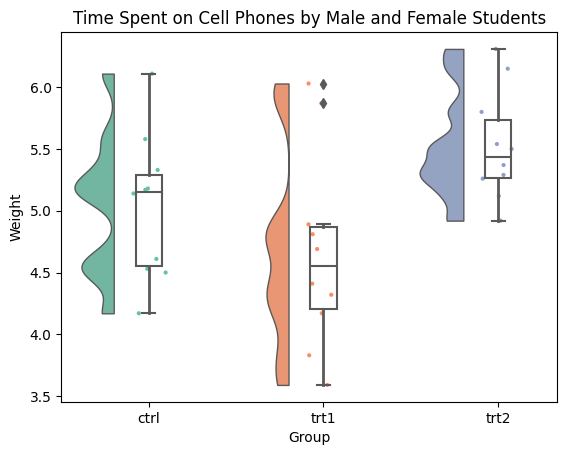

In [122]:

pt.RainCloud(data=df, x='group', y='weight', width_viol=0.5)
plt.title('Time Spent on Cell Phones by Male and Female Students')
plt.xlabel('Group')
plt.ylabel('Weight')
plt.show()

In [123]:
def extreme_outliers(df):
    df = df
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    extreme_outliers = df[(df < Q1 - 3 * IQR) | (df > Q3 + 3 * IQR)]
    return extreme_outliers

outliers_ctrl,outliers_trt1, outliers_trt2 = extreme_outliers(ctrl), extreme_outliers(trt1), extreme_outliers(trt2)
extreme_outliers = pd.concat([outliers_ctrl,outliers_trt1, outliers_trt2])

display(HTML("""<h5>Extreme Outliers</h5>"""))
if extreme_outliers.empty:
    display(HTML("""<p>None</p>"""))
else:
    display(extreme_outliers)

display(HTML("""<p>Remarks: Two outliers are found in the trt1 group by visual inspection of the plots. However, 
no extreme outliers are found outside 3 times the IQR from the first and third quartiles.</p>"""))

**Assumption 5:** Your dependent variable should be approximately normally distributed for each group of the independent variable.


In [124]:
def describe(df):
    count = df.count().to_frame(name="Valid").transpose()
    measures = df.agg(['mean', 'std', 'var', 'skew', 'kurt'])
    measures = measures.rename(index={'mean': 'Mean','std': 'Standard Deviation', 'var': 'Variance','skew': 'Skewness','kurt': 'Kurtosis'})
    missing = df.isna().sum()
    measures.loc['Missing'] = missing

    skew_err_formula = lambda x: np.sqrt((6 * len(x) * (len(x)-1)) / ((len(x)-2) * (len(x)+1) * (len(x)+3)))
    skew_stderror = df.apply(skew_err_formula)
    skew_stderror = skew_stderror.to_frame(name='Std. Error of Skewness').transpose()

    kurt_err_formula = lambda x: np.sqrt((24 * len(x) * (len(x) - 1) * (len(x) - 1)) / ((len(x) - 3) * (len(x) - 2) * (len(x) + 3) * (len(x) + 5)))
    kurt_stderror = df.apply(kurt_err_formula)
    kurt_stderror = kurt_stderror.to_frame(name='Std. Error of Kurtosis').transpose()
    
    table_df = pd.concat([count, measures,skew_stderror, kurt_stderror])
    table_df = table_df.reindex(['Valid','Missing', 'Mean', 'Standard Deviation', 'Variance', 
                                 'Skewness', 'Std. Error of Skewness','Kurtosis', 'Std. Error of Kurtosis'])
    return table_df

In [125]:
display(HTML("""<h5>Descriptive Statistics</h5>"""))
summary_ctrl, summary_trt1, summary_trt2 = describe(ctrl_df), describe(trt1_df), describe(trt2_df)

summary = (pd.concat([summary_ctrl, summary_trt1, summary_trt2],axis=1))
shapiro_ctrl, shapiro_trt1, shapiro_trt2 = shapiro(ctrl_df), shapiro(trt1_df), shapiro(trt2_df)
shapiro_ctrl = pd.DataFrame({'ctrl': shapiro_ctrl})
shapiro_trt1 = pd.DataFrame({'trt1': shapiro_trt1})
shapiro_trt2 = pd.DataFrame({'trt2': shapiro_trt2})
shapiro_df = pd.concat([shapiro_ctrl,shapiro_trt1, shapiro_trt2],axis=1).rename(index={0:'Shapiro-Wilk', 1:'P-value'})

display(pd.concat([summary,shapiro_df]))
display(HTML("""<p>Remark: As assessed by Shapiro-Wilk's test for normality, the data is normally distributed (p>0.05)
        for each group.</p>"""))

,ctrl,trt1,trt2
Valid,10.000,10.000,10.000
Missing,0.000,0.000,0.000
Mean,5.032,4.661,5.526
Standard Deviation,0.583,0.794,0.443
Variance,0.340,0.630,0.196
Skewness,0.321,0.659,0.673
Std. Error of Skewness,0.687,0.687,0.687
Kurtosis,-0.229,-0.203,-0.324
Std. Error of Kurtosis,1.334,1.334,1.334
Shapiro-Wilk,0.957,0.930,0.941


**Assumption 6:** You have homogeneity of variances (i.e., the variance of the dependent variable is equal in each group of your independent variable).

In [127]:
levene_test = levene(ctrl, trt1, trt2)
levene_df = pd.DataFrame({'': levene_test}).rename(index={0:'F', 1:'p'}).transpose()
levene_df['df1'], levene_df['df2'] =[2],[27]

display(HTML("""<h5>Test for Equality of Variances (Levene's)</h5>"""))
display(levene_df)
display(HTML("""<p>Remark: As assessed by Levene's test for homogeneity of variances (p>0.05), there is no significant difference
between the variances of the groups.</p>"""))

,F,p,df1,df2
,1.119,0.341,2,27


#### Computation

In [128]:
aov = pg.anova(dv='weight', between='group', data=df, detailed =True)
aov = aov.rename(columns={'Source': 'Cases', 'SS':'Sum of Squares', 'MS':'Mean Square', 'p-unc':'p'})
aov = aov.replace(['Within', np.nan], ['Residuals', ''])
display(HTML("""<h5>ANOVA</h5>"""),aov, HTML("""<p>Note: Type III Sum of Squares</p>"""))
display(HTML("""<h5><br>Descriptives</h5>"""))

display(summary.iloc[[0,2,3]])

,Cases,Sum of Squares,DF,Mean Square,F,p,np2
0,group,3.766,2,1.883,4.846,0.016,0.264
1,Residuals,10.492,27,0.389,,,


,ctrl,trt1,trt2
Valid,10.000,10.000,10.000
Mean,5.032,4.661,5.526
Standard Deviation,0.583,0.794,0.443


In [129]:
model = ols('weight ~ group', data=df).fit()
anova_table = anova_lm(model, typ=3)
tukey = pairwise_tukeyhsd(df['weight'], df['group'], alpha=0.05)

tukey_results = tukey.summary().data[1:]
tukey_df = pd.DataFrame(tukey_results, columns=['group1', 'group2', 'Mean Difference', 'p', 'Lower', 'Upper', 'Reject'])

display(HTML("""<h5>Post Hoc Comparisons - Group</h5>"""), tukey_df)

,group1,group2,Mean Difference,p,Lower,Upper,Reject
0,ctrl,trt1,-0.371,0.391,-1.062,0.320,False
1,ctrl,trt2,0.494,0.198,-0.197,1.185,False
2,trt1,trt2,0.865,0.012,0.174,1.556,True


#### Report
 
A one-way ANOVA was conducted to determine if the yields (measured by weight) is different for plants grouped by different conditions. Cases were classified into four groups: ctrl (short for Controlled) (n = 10), trt1 (Treatment 1) (n = 10), and trt2 (Treatment 2) (n=10). As assessed by visual inspection of box plots, but are not extreme by the IQR method of identifying outliers; data was normally distributed for each group as assessed by Shapiro-Wilk test (p>0.05); and there was homogeneity of variance as assessed by Levene's test of homogeneity (p>0.05).

The one-way ANOVA results indicated no significant difference between the ctrl group (M = 5.03, SD = 0.583), trt1 group (M = 4.66, SD = 0.79), and trt2 group (M = 5.53, SD = 0.44). The tukey post-hoc analysis revealed that only the difference between trt2 and trt1 is statistically significant with adjusted p-value of 0.012.